<a href="https://colab.research.google.com/github/chloecasserly/Electrifying-Tractors-for-Farming-and-Electricity-Grid-Integration/blob/main/TractorOptimisationv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Optimisation Code v2

CODE INSTRUCTIONS:
1. Enter Data into '01. User Input' Section and run the cell.
2. Upload Files following instructions in '02. File Upload' section
3. Run '03. Data Processing' Section, ensure it prints the correct data length value
   (8760) and shows excel output snip it correctly.
4. Run '04. Initialise/Reset Optimisation'
5. Run '05. Structured Optimisation'
6. Run '06. Solve Model', will output total cost and time to optimise
7. Run '01. User Input' again to ensure correct title output
8. Run '07. Print to Excel' to store data in excel
9. Run '08. Plot Results' to see graphs

"""



# 01. User Input

In [10]:
"""
User Data is to be entered in this cell.
--------------------------------------------------------------------------------
Scenario Name
  Enter the name that will be used to name the output files.

Scenario Inputs
  Enter (1 or 0) to turn (on or off) PV, BESS (Residential or Wholesale), CAPEX
  and FCAS.

System Values
  Enter number of tractors, current interest rate, lifetime of proposed system,
  efficicencies, CAPEX and OandM
--------------------------------------------------------------------------------
Calculations for Optimisation
  NOT for data input, DO NOT CHANGE VALUES

"""

# User Input for Optimisation --------------------------------------------------
# Scenario Name
name = "Testing with no FCAS"

# Scenario inputs (0 or 1)
# Scenarios:
# A-PVO - PV Only
# A-BO - BESS Only
# A-PVB - PV and BESS
pv = 1
bess_R = 1
bess_W = 1
capex = 1
fcas = 0

# System Values
no_tractors = 2 # Indicate number of tractors in system (0-inf)
interest_rate = 0.044 # Interest rate at time
lifetime = 30 # Lifetime of the total system
eff_in = 0.9 # Charge Efficiency of Residential and Wholesale BESS (default - 0.9)
eff_out = 0.9 # Discharge Efficiency of Residential and Wholesale BESS (default - 0.9)
eff_tractor = 0.9 # Tractor Battery Efficiency (default - 0.9)
CAPEX_tractor = 155711
OandM_tractor = 25000
capex_pv = 65623
oandm_pv = 44.198
capex_bess = 29300
oandm_bess = 4.3274

# Calculations for Optimisation Input ------------------------------------------
# DO NOT CHANGE ----------------------------------------------------------------
# Capital Recover Factor Formula
CRF = (interest_rate * (1 + interest_rate)**lifetime) / ((1 + interest_rate)**lifetime - 1)

# Logic to set CAPEX and OandM to 0 when relevant system component is not in use
if pv == 0: # OandM and Capex for PV is 0 when flag not indicated
  OandM_PV = 0
  CAPEX_PV = 0
else:
  OandM_PV = oandm_pv
  CAPEX_PV = capex_pv

if bess_W == 0 or bess_R == 0: # OandM and Capex for BESS is 0 when flag not indicated
  OandM_BESS = 0
  CAPEX_BESS = 0
else:
  OandM_BESS = oandm_bess
  CAPEX_BESS = capex_bess

# 02. File Upload


In [2]:
from google.colab import files;
uploaded = files.upload()

"""
Upload the following files for the code to run:

Currently Used
 - 'Model RF Tractor Use.xlsx'
 - 'Model NEM Spot Price Full.xlsx'
 - 'Model TOU Cost ActewAGL 2025.xlsx'
 - 'Model TOU Cost Essential Energy 2025.xlsx'
 - 'Model PV Generation.xlsx'
 - 'Model Electricity Profile V1.xlsx'
 - 'Model FCAS Acceptance.xlsx'
 - 'Model Yearly FCAS Prices.xlsx'


Link to all model files
https://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do
"""

Saving Model Yearly FCAS Prices.xlsx to Model Yearly FCAS Prices.xlsx
Saving Model FCAS Acceptance.xlsx to Model FCAS Acceptance.xlsx
Saving Model TOU Cost Essential Energy 2025.xlsx to Model TOU Cost Essential Energy 2025.xlsx
Saving Model TOU Cost ActewAGL 2025.xlsx to Model TOU Cost ActewAGL 2025.xlsx
Saving Model RF Tractor Use.xlsx to Model RF Tractor Use.xlsx
Saving Model PV Generation.xlsx to Model PV Generation.xlsx
Saving Model NEM Spot Price Full.xlsx to Model NEM Spot Price Full.xlsx
Saving Model Electricity Profile V1.xlsx to Model Electricity Profile V1.xlsx


"\nUpload the following files for the code to run:\n\nCurrently Used\n - 'Model RF Tractor Use.xlsx'\n - 'Model NEM Spot Price Full.xlsx'\n - 'Model TOU Cost ActewAGL 2025.xlsx'\n - 'Model TOU Cost Essential Energy 2025.xlsx'\n - 'Model PV Generation.xlsx'\n - 'Model Electricity Profile V1.xlsx'\n - 'Model FCAS Acceptance.xlsx'\n - 'Model Yearly FCAS Prices.xlsx'\n\n\nLink to all model files\nhttps://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do\n"

# 03. Data Processing

In [3]:
import pandas as pd
from pyomo.environ import *
!apt-get install -y -qq glpk-utils

# Data Import and Processing ---------------------------------------------------
# Tractor Use (Options A -> D)
# Slashing and Undervine Spraying can be done in 1 day or split over 2 days
# 1 day Slashing and Undervine Spraying
excel_tractor_use_A = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load A', usecols = 'I', header=1)
# 1 day Slashing and 2 days Undervine Spraying
excel_tractor_use_B = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load B', usecols = 'I', header=1)
# 2 days Slashing and 1 day Undervine Spraying
excel_tractor_use_C = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load C', usecols = 'I', header=1)
# 2 days Slashing and 2 days Undervine Spraying
excel_tractor_use_D = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load D', usecols = 'I', header=1)
# Note: header=1 is used as document has two header rows

# Wholesale Electricity Prices (SPOT Prices from NEM)
excel_spot_price = pd.read_excel('Model NEM Spot Price Full.xlsx', usecols='I')

# Farm Electricity Profile
excel_ele_profile = pd.read_excel('Model Electricity Profile V1.xlsx', sheet_name='Total Profile' ,usecols='I')

# PV Generation
excel_PV = pd.read_excel('Model PV Generation.xlsx', usecols='I')

# ActewAGL Residential Electricity Costs
# ActewAGL Plan 1 (Home_Plan_Price_Per_kWh)
excel_R_A1 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='C')
# ActewAGL Energy Plan 2 (Home_Time_Of_Use_Plan_Price_Per_kWh)
excel_R_A2 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='D')
# ActewAGL Plan 3 (Home_Daytime_Economy_Plan_Price_Per_kWh)
excel_R_A3 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='E')

# Essential Energy Residential Electricity Costs
# Essential Energy Plan 1 (Residential_Time_Of_Use_Opt_In_Demand_Plan_Price_Per_kWh)
excel_R_E1 = pd.read_excel('Model TOU Cost Essential Energy 2025.xlsx', usecols='C')
# Essential Energy Energy Plan 2 (Residential_Time_Of_Use_Sun_Soaker_Plan_Price_Per_kWh)
excel_R_E2 = pd.read_excel('Model TOU Cost Essential Energy 2025.xlsx', usecols='D')

# FCAS Acceptance
# Raise 1s
acc_raise_1s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='C')
# Raise 6s
acc_raise_6s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='D')
# Raise 60s
acc_raise_60s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='E')
# Raise 5m
acc_raise_5m = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='F')
# Lower 1s
acc_lower_1s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='H')
# Lower 6s
acc_lower_6s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='I')
# Lower 60s
acc_lower_60s = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='J')
# Lower 5m
acc_lower_5m = pd.read_excel('Model FCAS Acceptance.xlsx', usecols='K')

# FCAS Market Prices
# Raise 1s
price_raise_1s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='I')
# Raise 6s
price_raise_6s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='C')
# raise 60s
price_raise_60s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='D')
# Raise 5m
price_raise_5m = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='E')
# Lower 1s
price_lower_1s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='J')
# Lower 6s
price_lower_6s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='F')
# Lower 60s
price_lower_60s = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='G')
# Lower 5m
price_lower_5m = pd.read_excel('Model Yearly FCAS Prices.xlsx', usecols='H')

# Create index of no. data points (Each hour of a year = 8760)
data_length = list(range(len(excel_tractor_use_A)))

# CODE CHECKS
print(len(data_length))
print(excel_tractor_use_A.head())


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

# 04. Initialise/Reset Optimisation

In [4]:
"""
Structured Optimisation following 'Updated_Optimisation_5.4'
"""
# Optimisation Set Up ------------------------------------------------------

# Create Pyomo model "modelv1"
modelv1 = ConcreteModel()
# Make index for days
modelv1.T = Set(initialize=data_length)

# Make index for SOC Constraints that use [t-1] and [t+1]
T_SOC_indices = data_length[:-1]  # all t where t+1 is valid
modelv1.T_SOC = Set(initialize=T_SOC_indices)

# Set Range for number of tractors
modelv1.N = RangeSet(no_tractors)

# 05. Structured Optimisation

Current Optimisation Status Notes:
1. Validate data for eff and upfront costs with hosts
4. grid_limit_rule could use same binary variables as fcas
5. Add in postcode functionality
6. Need to translate all code back to optimisation document




In [8]:
"""
Structured Optimisation following 'Updated_Optimisation_5.4'
"""
from pyomo.environ import inequality
from pyomo.environ import *

# Fixed Variables --------------------------------------------------------------

# 1.0 Variables and Parameters -------------------------------------------------

# 1.1 Decision Variables (Decided by optimisation)
# Status: DONE
# Variables are non-negative and part of indexed set "modelv1.T"
modelv1.grid_imp_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.grid_exp_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.grid_imp_R = Var(modelv1.T, domain=NonNegativeReals)

modelv1.BESS_in_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.BESS_out_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.BESS_in_R = Var(modelv1.T, domain=NonNegativeReals)
modelv1.BESS_out_R = Var(modelv1.T, domain=NonNegativeReals)

modelv1.tractor_in = Var(modelv1.T, modelv1.N, domain=NonNegativeReals)
modelv1.tractor_out = Var(modelv1.T, modelv1.N, domain=NonNegativeReals)

modelv1.PV_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.PV_R = Var(modelv1.T, domain=NonNegativeReals)

modelv1.farm = Var(modelv1.T, domain=NonNegativeReals)

modelv1.SOC_BESS_W = Var(modelv1.T, domain=NonNegativeReals)
modelv1.SOC_BESS_R = Var(modelv1.T, domain=NonNegativeReals)
modelv1.SOC_tractor = Var(modelv1.T, modelv1.N, domain=NonNegativeReals)

modelv1.f_R1s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_R6s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_R60s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_R5m = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_L1s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_L6s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_L60s = Var(modelv1.T, domain=NonNegativeReals)
modelv1.f_L5m = Var(modelv1.T, domain=NonNegativeReals)

modelv1.z_raise = Var(modelv1.T, domain=Binary)
modelv1.z_lower = Var(modelv1.T, domain=Binary)

modelv1.grid_dir = Var(modelv1.T, domain=Binary)

# 1.2 Model Parameters and Inputs (Should be assigned a value immediately from imported models or elsewhere
# Status: Partially Done - Grid_max to be added
modelv1.PV_cap = Param(initialize=2) # kW (KWp) (doc ref - Model PV Generation)

modelv1.BESS_cap_W = Param(initialize=67.5) # kWh (doc ref - Research Battery BESS Fendt tractor chosen)
modelv1.BESS_cap_R = Param(initialize=67.5) # kWh

modelv1.tractor_cap = Param(initialize=100) #kWh (doc ref - Research Tractor and Battery)

modelv1.BESS_max_W = Param(initialize=105) # kWh (doc ref - Research Battery BESS)
modelv1.BESS_max_R = Param(initialize=75) # kWh

modelv1.tractor_max = Param(initialize=14.28) # kWh (doc ref - Research Battery BESS (Fendt tractor chosen))

modelv1.grid_max = Param(initialize=15) # !! Rohan is collating better data for this

modelv1.tractor_load = Param(modelv1.T, initialize=excel_tractor_use_A) # Tractor Usage Profile A (Can choose A-D)
modelv1.farm_load = Param(modelv1.T, initialize=excel_ele_profile) # Farm Load
modelv1.PV = Param(modelv1.T, initialize=excel_PV) # kWh

modelv1.price_W = Param(modelv1.T, initialize=excel_spot_price) # NEM SPOT Prices
modelv1.price_R = Param(modelv1.T, initialize=excel_R_A1) # ActewAGL Plan 1 used here

modelv1.price_R1s = Param(modelv1.T, initialize=price_raise_1s) # ActewAGL Plan 1 used here
modelv1.price_R6s = Param(modelv1.T, initialize=price_raise_6s)
modelv1.price_R60s = Param(modelv1.T, initialize=price_raise_60s)
modelv1.price_R5m = Param(modelv1.T, initialize=price_raise_5m)
modelv1.price_L1s = Param(modelv1.T, initialize=price_lower_1s)
modelv1.price_L6s = Param(modelv1.T, initialize=price_lower_6s)
modelv1.price_L60s = Param(modelv1.T, initialize=price_lower_60s)
modelv1.price_L5m = Param(modelv1.T, initialize=price_lower_5m)

modelv1.e_R1s = Param(modelv1.T, initialize=acc_raise_1s) # kW (doc ref - Model FCAS Acceptance)
modelv1.e_R6s = Param(modelv1.T, initialize=acc_raise_6s)
modelv1.e_R60s = Param(modelv1.T, initialize=acc_raise_60s)
modelv1.e_R5m = Param(modelv1.T, initialize=acc_raise_5m)
modelv1.e_L1s = Param(modelv1.T, initialize=acc_lower_1s)
modelv1.e_L6s = Param(modelv1.T, initialize=acc_lower_6s)
modelv1.e_L60s = Param(modelv1.T, initialize=acc_lower_60s)
modelv1.e_L5m = Param(modelv1.T, initialize=acc_lower_5m)

modelv1.CRF = Param(initialize=CRF) # The following are entered in 'User Input'
modelv1.CAPEX_tractor = Param(initialize=CAPEX_tractor)
modelv1.CAPEX_PV = Param(initialize=CAPEX_PV)
modelv1.CAPEX_BESS = Param(initialize=CAPEX_BESS)
modelv1.OandM_tractor = Param(initialize=OandM_tractor)
modelv1.OandM_PV = Param(initialize=OandM_PV)
modelv1.OandM_BESS = Param(initialize=OandM_BESS)
modelv1.eff_in = Param(initialize=eff_in)
modelv1.eff_out = Param(initialize=eff_out)
modelv1.eff_tractor = Param(initialize=eff_tractor)


# 1.3 Scenario Flags (Binary Values)
# Status: DONE
# Flags = 1 indicates using PV,BESS (W or R),CAPEX or FCAS
delta_PV = pv
delta_BESS_W = bess_W
delta_BESS_R = bess_R
delta_CAPEX = capex
delta_FCAS = fcas

# Fixing Values for Scenarios
if delta_BESS_W == 0:
    modelv1.BESS_out_W.fix(0)
    modelv1.BESS_in_W.fix(0)
else:
    modelv1.BESS_in_W.unfix()
    modelv1.BESS_out_W.unfix()

if delta_BESS_R == 0:
    modelv1.BESS_out_R.fix(0)
    modelv1.BESS_in_R.fix(0)
else:
    modelv1.BESS_in_R.unfix()
    modelv1.BESS_out_R.unfix()

if delta_PV == 0:
    modelv1.PV_W.fix(0)
    modelv1.PV_R.fix(0)
else:
    modelv1.PV_W.unfix()
    modelv1.PV_R.unfix()

if delta_FCAS == 0:
    modelv1.f_R1s.fix(0)
    modelv1.f_R6s.fix(0)
    modelv1.f_R60s.fix(0)
    modelv1.f_R5m.fix(0)
    modelv1.f_L1s.fix(0)
    modelv1.f_L6s.fix(0)
    modelv1.f_L60s.fix(0)
    modelv1.f_L5m.fix(0)
else:
    modelv1.f_R1s.unfix()
    modelv1.f_R6s.unfix()
    modelv1.f_R60s.unfix()
    modelv1.f_R5m.unfix()
    modelv1.f_L1s.unfix()
    modelv1.f_L6s.unfix()
    modelv1.f_L60s.unfix()
    modelv1.f_L5m.unfix()

# 2.0 Objective Function -------------------------------------------------------
# Status: DONE
# Define Objective in function
def obj_rule(m):
    grid_cost = sum(modelv1.price_W[t] * (modelv1.grid_imp_W[t] -
                                          modelv1.grid_exp_W[t]) +
                    modelv1.price_R[t] * (modelv1.grid_imp_R[t] - modelv1.farm[t])
                    - delta_FCAS * (((modelv1.e_R1s[t] * modelv1.price_R1s[t] *
                                      modelv1.f_R1s[t]) +
                    (modelv1.e_R6s[t] * modelv1.price_R6s[t] * modelv1.f_R6s[t]) +
                    (modelv1.e_R60s[t] * modelv1.price_R60s[t] * modelv1.f_R60s[t]) +
                    (modelv1.e_R5m[t] * modelv1.price_R5m[t] * modelv1.f_R5m[t]) +
                    (modelv1.e_L1s[t] * modelv1.price_L1s[t] * modelv1.f_L1s[t]) +
                    (modelv1.e_L6s[t] * modelv1.price_L6s[t] * modelv1.f_L6s[t]) +
                    (modelv1.e_L60s[t] * modelv1.price_L60s[t] * modelv1.f_L60s[t]) +
                    (modelv1.e_L5m[t] * modelv1.price_L5m[t] * modelv1.f_L5m[t])))
                    for t in m.T)
    return (grid_cost + delta_CAPEX *
            modelv1.CRF * (no_tractors * modelv1.CAPEX_tractor
                           + modelv1.CAPEX_PV + modelv1.CAPEX_BESS)
            + (modelv1.OandM_PV * modelv1.PV_cap)
            + (modelv1.OandM_BESS * modelv1.BESS_cap_W)
            + modelv1.OandM_tractor)
# Set Model OBJECTIVE function
modelv1.obj = Objective(rule=obj_rule, sense=minimize)


# 3.0 Constraints --------------------------------------------------------------
# These should be based on 1.1 and 1.2

# 3.1 Energy Balance
# Status: DONE
def energy_balance(m, t):
    return  ((modelv1.grid_imp_W[t] + modelv1.grid_imp_R[t] +
            delta_PV *(modelv1.PV_W[t] +
            modelv1.PV_R[t]) + delta_BESS_R * modelv1.BESS_out_R[t] +
            delta_BESS_W * modelv1.BESS_out_W[t] +
            sum(modelv1.tractor_out[t,n] for n in modelv1.N))
            ==
            (modelv1.farm[t] + delta_BESS_R * modelv1.BESS_in_R[t] +
            delta_BESS_W * modelv1.BESS_in_W[t] + modelv1.grid_exp_W[t]
            + sum(modelv1.tractor_in[t,n] for n in modelv1.N)))
modelv1.energy_constraint = Constraint(modelv1.T, rule=energy_balance)

# 3.2 Wholesale System Dynamics
# Status: DONE
def power_imp_balance_W(m, t):
  if delta_BESS_W == 1:
    return modelv1.grid_imp_W[t] + modelv1.PV_W[t]  == modelv1.BESS_in_W[t]
  else:
    return Constraint.Skip
modelv1.power_exp_W_constraint = Constraint(modelv1.T, rule=power_imp_balance_W)

def power_exp_balance_W(m, t):
  if delta_BESS_W == 1:
    return modelv1.grid_exp_W[t] == modelv1.BESS_out_W[t]
  elif delta_PV == 1 and delta_BESS_W == 0:
    return modelv1.grid_exp_W[t] == modelv1.PV_W[t]
  else:
    return Constraint.Skip
modelv1.power_imp__W_constraint = Constraint(modelv1.T, rule=power_exp_balance_W)

def battery_soc_W(m, t):
  if delta_BESS_W == 1:
    return (modelv1.SOC_BESS_W[t+1] == modelv1.SOC_BESS_W[t] +
           (modelv1.eff_in * modelv1.BESS_in_W[t]) - ((1/modelv1.eff_out)*modelv1.BESS_out_W[t]))
  else:
    return Constraint.Skip
modelv1.battery_soc_W_constraint = Constraint(modelv1.T_SOC, rule=battery_soc_W)

def battery_cap_range_W(m, t):
  if delta_BESS_W == 1:
    return (modelv1.SOC_BESS_W[t] <= modelv1.BESS_cap_W)
  else:
    return Constraint.Skip
modelv1.battery_cap_range_W_constraint = Constraint(modelv1.T, rule=battery_cap_range_W)

# 3.3 Residential System Dynamics
# Status: DONE
def power_exp_balance_R(m, t):
    return (modelv1.farm[t] == modelv1.BESS_out_R[t]
            + sum(modelv1.tractor_out[t,n] for n in modelv1.N))
modelv1.power_exp_R_constraint = Constraint(modelv1.T, rule=power_exp_balance_R)

def power_imp_balance_R(m, t):
    return (modelv1.PV_R[t] + modelv1.grid_imp_R[t] == modelv1.BESS_in_R[t]
            + sum(modelv1.tractor_in[t,n] for n in modelv1.N))
modelv1.power_imp_R_constraint = Constraint(modelv1.T, rule=power_imp_balance_R)

def battery_soc_R(m, t):
  if delta_BESS_R == 1:
    return (modelv1.SOC_BESS_R[t+1] == modelv1.SOC_BESS_R[t] +
           (eff_in * modelv1.BESS_in_R[t]) - ((1/eff_out)*modelv1.BESS_out_R[t]))
  else:
    return Constraint.Skip
modelv1.battery_soc_R_constraint = Constraint(modelv1.T_SOC, rule=battery_soc_R)

def battery_cap_range_R(m, t):
  if delta_BESS_R == 1:
    return (modelv1.SOC_BESS_R[t] <= modelv1.BESS_cap_R)
  else:
    return Constraint.Skip
modelv1.battery_cap_range_R_constraint = Constraint(modelv1.T, rule=battery_cap_range_R)

# 3.4 Tractor Battery SOC Dynamics
# Status: DONE
def tractor_soc(m, t, n):
    return (modelv1.SOC_tractor[t+1, n] == modelv1.SOC_tractor[t, n] +
     (eff_in * modelv1.tractor_in[t, n]) - ((1/eff_out)*modelv1.tractor_out[t,n])
     - modelv1.tractor_load[t])
modelv1.tractor_soc_constraint = Constraint(modelv1.T_SOC, modelv1.N, rule=tractor_soc)

def tractor_cap_range(m, t, n):
    return (modelv1.SOC_tractor[t,n] <= modelv1.tractor_cap)
modelv1.tractor_cap_range_constraint = Constraint(modelv1.T, modelv1.N, rule=tractor_cap_range)

# 3.5 Power Limits
# Status: DONE
def PV_limit(m, t):
  if pv == 1:
    return (modelv1.PV_W[t] + modelv1.PV_R[t] == modelv1.PV[t])
  else:
    return Constraint.Skip
modelv1.PV_limit = Constraint(modelv1.T, rule=PV_limit)

def charge_limit_W(m, t):
  if delta_BESS_W == 1:
    return inequality(-1 * modelv1.BESS_max_W, modelv1.BESS_in_W[t] -
                      modelv1.BESS_out_W[t], modelv1.BESS_max_W)
  else:
    return Constraint.Skip
modelv1.charge_limit_W_constraint = Constraint(modelv1.T, rule=charge_limit_W)

def charge_limit_R(m, t):
  if delta_BESS_R == 1:
    return inequality(-1 * modelv1.BESS_max_R, modelv1.BESS_in_R[t] -
                      modelv1.BESS_out_R[t], modelv1.BESS_max_R)
  else:
    return Constraint.Skip
modelv1.charge_limit_R_constraint = Constraint(modelv1.T, rule=charge_limit_R)

def charge_limit_tractor(m, t, n):
    return inequality(-1 * modelv1.tractor_max, modelv1.tractor_in[t,n] -
                      modelv1.tractor_out[t,n], modelv1.tractor_max)
modelv1.charge_limit_tractor_constraint = Constraint(modelv1.T, modelv1.N, rule=charge_limit_tractor)

def grid_limit_imp_tractor(m, t):
    return inequality(0, modelv1.grid_imp_W[t] +
                      modelv1.grid_imp_R[t], modelv1.grid_max)
modelv1.grid_limit_imp_tractor_constraint = Constraint(modelv1.T, rule=grid_limit_imp_tractor)

def grid_limit_exp_tractor(m, t):
    return inequality(0, modelv1.grid_exp_W[t],
                      modelv1.grid_max)
modelv1.grid_limit_exp_tractor_constraint = Constraint(modelv1.T, rule=grid_limit_exp_tractor)

# 3.6 Grid Import/Export Constraints
# Status: DONE
def grid_imp_limit_rule(m, t):
    return modelv1.grid_imp_W[t]+ modelv1.grid_imp_R[t] <= modelv1.grid_max * modelv1.grid_dir[t]
modelv1.imp_limit_constraint = Constraint(modelv1.T, rule=grid_imp_limit_rule)

def grid_exp_limit_rule(m, t):
    return modelv1.grid_exp_W[t] <= modelv1.grid_max * (1-modelv1.grid_dir[t])
modelv1.exp_limit_constraint = Constraint(modelv1.T, rule=grid_exp_limit_rule)

# 3.7 Tractor Usage Constraint
# Status: DONE
def farm_load(m, t):
    return modelv1.farm[t] <= modelv1.farm_load[t]
modelv1.farm_load_constraint = Constraint(modelv1.T, rule=farm_load)

def tractor_load(m, t, n):
    return modelv1.SOC_tractor[t, n] >= modelv1.tractor_load[t]
modelv1.tractor_load_constraint = Constraint(modelv1.T, modelv1.N, rule=tractor_load)


# 3.8 FCAS Power Availability
# Status: DONE
def raise_power_availability(m, t):
    return (modelv1.BESS_out_W[t] + modelv1.f_R1s[t] + modelv1.f_R6s[t]
            + modelv1.f_R60s[t] + modelv1.f_R5m[t] <= modelv1.BESS_max_W)
modelv1.raise_availability_constraint = Constraint(modelv1.T, rule=raise_power_availability)

def lower_power_availability(m, t):
    return (modelv1.BESS_out_W[t] + modelv1.f_L1s[t] + modelv1.f_L6s[t]
            + modelv1.f_L60s[t] + modelv1.f_L5m[t] <= modelv1.BESS_max_W)
modelv1.lower_availability_constraint = Constraint(modelv1.T, rule=lower_power_availability)

# 3.9 FCAS SoC Availability Constraints
# Status: DONE
def raise_activation_logic(m, t):
    return modelv1.SOC_BESS_W[t] >= 0.2 * modelv1.BESS_cap_W - modelv1.BESS_cap_W * (1 - modelv1.z_raise[t])
modelv1.raise_activation_constraint = Constraint(modelv1.T, rule=raise_activation_logic)

def lower_activation_logic(m, t):
    return modelv1.SOC_BESS_W[t] <= 0.8 * modelv1.BESS_cap_W + modelv1.BESS_cap_W * (1 - modelv1.z_lower[t])
modelv1.lower_activation_constraint = Constraint(modelv1.T, rule=lower_activation_logic)

def raise_disable_logic_R1s(m, t):
    return modelv1.f_R1s[t] <= modelv1.BESS_cap_W * modelv1.z_raise[t]
modelv1.raise_disable_R1s_constraint = Constraint(modelv1.T, rule=raise_disable_logic_R1s)

def raise_disable_logic_R6s(m, t):
    return modelv1.f_R6s[t] <= modelv1.BESS_cap_W * modelv1.z_raise[t]
modelv1.raise_disable_R6s_constraint = Constraint(modelv1.T, rule=raise_disable_logic_R6s)

def raise_disable_logic_R60s(m, t):
    return modelv1.f_R60s[t] <= modelv1.BESS_cap_W * modelv1.z_raise[t]
modelv1.raise_disable_R60s_constraint = Constraint(modelv1.T, rule=raise_disable_logic_R60s)

def raise_disable_logic_R5m(m, t):
    return modelv1.f_R5m[t] <= modelv1.BESS_cap_W * modelv1.z_raise[t]
modelv1.raise_disable_R5m_constraint = Constraint(modelv1.T, rule=raise_disable_logic_R5m)

def lower_disable_logic_L1s(m, t):
    return modelv1.f_L1s[t] <= modelv1.BESS_cap_W * modelv1.z_lower[t]
modelv1.lower_disable_L1s_constraint = Constraint(modelv1.T, rule=lower_disable_logic_L1s)

def lower_disable_logic_L6s(m, t):
    return modelv1.f_L6s[t] <= modelv1.BESS_cap_W * modelv1.z_lower[t]
modelv1.lower_disable_L6s_constraint = Constraint(modelv1.T, rule=lower_disable_logic_L6s)

def lower_disable_logic_L60s(m, t):
    return modelv1.f_L60s[t] <= modelv1.BESS_cap_W * modelv1.z_lower[t]
modelv1.lower_disable_L60s_constraint = Constraint(modelv1.T, rule=lower_disable_logic_L60s)

def lower_disable_logic_L5m(m, t):
    return modelv1.f_L5m[t] <= modelv1.BESS_cap_W * modelv1.z_lower[t]
modelv1.lower_disable_L5m_constraint = Constraint(modelv1.T, rule=lower_disable_logic_L5m)

# 3.10 FCAS Total Capacity Constraint
# Status: DONE
def raise_fcas_capacity(m, t):
    return (modelv1.f_R1s[t] + modelv1.f_R6s[t] + modelv1.f_R60s[t] + modelv1.f_R5m[t] +
            modelv1.f_L1s[t] + modelv1.f_L6s[t] + modelv1.f_L60s[t] + modelv1.f_L5m[t] <= modelv1.BESS_max_W)
modelv1.raise_fcas_capacity_constraint = Constraint(modelv1.T, rule=raise_fcas_capacity)

# 3.11 FCAS Exclusivity Constraint
# Status: DONE
def fcas_exclusive(m, t):
    return m.z_raise[t] + m.z_lower[t] <= 1
modelv1.fcas_exclusive_constraint = Constraint(modelv1.T, rule=fcas_exclusive)


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# 06. Solve Model

In [9]:
import time
t0 = time.time()
# Solve the model
solver = SolverFactory('highs')
results = solver.solve(modelv1, tee= True, options={
        "mip_rel_gap": 0.02,   # stop when within 2% of optimal
        "time_limit": 120      # stop after 2 minutes
    })

# Output total cost and first few values
print('Optimisation complete')
print("Total annual cost: $", round(value(modelv1.obj), 2))
t1 = time.time()
print("Total time to solve optimisation:",(t1-t0),'s')

Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 341636 rows; 254040 cols; 744584 nonzeros; 26280 integer variables (26280 binary)
Coefficient ranges:
  Matrix [9e-01, 7e+01]
  Cost   [7e-06, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [2e-04, 1e+02]
Presolving model
140156 rows, 142364 cols, 459912 nonzeros  0s
97342 rows, 120093 cols, 348137 nonzeros  1s
79468 rows, 116713 cols, 279886 nonzeros  2s

Solving MIP model with:
   79468 rows
   116713 cols (8759 binary, 0 integer, 0 implied int., 107954 continuous, 0 domain fixed)
   279886 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |    

# 07. Print to Excel

In [11]:
# Print out Solution to Excel
from pyomo.environ import value
import pandas as pd
import numpy as np

# Extract time steps (x-axis)
timesteps = list(modelv1.T)

# Start building your data dictionary with 'Time Step' always included
data = {
    'Time Step': timesteps
}

# Conditionally add columns matching plotting logic
if bess_R == 1:
    data.update({
        'SOC_BESS_R': [value(modelv1.SOC_BESS_R[t]) for t in timesteps],
        'BESS_in_R': [value(modelv1.BESS_in_R[t]) for t in timesteps],
        'BESS_out_R': [value(modelv1.BESS_out_R[t]) for t in timesteps],
    })

if bess_W == 1:
    data.update({
        'SOC_BESS_W': [value(modelv1.SOC_BESS_W[t]) for t in timesteps],
        'BESS_in_W': [value(modelv1.BESS_in_W[t]) for t in timesteps],
        'BESS_out_W': [value(modelv1.BESS_out_W[t]) for t in timesteps],
    })

# Grid flows are always included (no condition on your plotting)
data.update({
    'grid_imp_W': [value(modelv1.grid_imp_W[t]) for t in timesteps],
    'grid_exp_W': [value(modelv1.grid_exp_W[t]) for t in timesteps],
    'grid_imp_R': [value(modelv1.grid_imp_R[t]) for t in timesteps],
})

# Tractor flows always included as well
for n in modelv1.N:
    data[f'tractor_in_{n}'] = [value(modelv1.tractor_in[t, n]) for t in timesteps]
    data[f'tractor_out_{n}'] = [value(modelv1.tractor_out[t, n]) for t in timesteps]
    data[f'SOC_tractor_{n}'] = [value(modelv1.SOC_tractor[t, n]) for t in timesteps]

if pv == 1:
    data.update({
        'PV_W': [value(modelv1.PV_W[t]) for t in timesteps],
        'PV_R': [value(modelv1.PV_R[t]) for t in timesteps],
    })

# Farm data always included
data['farm'] = [value(modelv1.farm[t]) for t in timesteps]

# Create DataFrame with the filtered columns
df = pd.DataFrame(data)

# Build summary dataframe
summary = pd.DataFrame({
    "Metric": ["Total Cost", "Total Time (s)"],
    "Value": [round(value(modelv1.obj), 2), round(t1 - t0, 2)]
})

# Write both to Excel (two sheets)
output_path = f"{name}_results.xlsx"
with pd.ExcelWriter(output_path) as writer:
    df.to_excel(writer, sheet_name="TimeSeries", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)

print(f"Results exported to {output_path}")

from google.colab import files
files.download(output_path)


Results exported to Testing with no FCAS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 08. Plot Results

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyomo.environ import value

# Define timesteps and dates
timesteps = list(modelv1.T)
start_date = '2025-01-01'
dates = pd.date_range(start=start_date, periods=len(timesteps), freq='h')

# Select months to plot (e.g., March to May)
months_to_plot = [3]
mask = dates.month.isin(months_to_plot)
filtered_dates = dates[mask]

# Helper function to plot series with optional moving average
def plot_series(dates, series_dict, title, ylabel='kWh', window=None):
    # --- Plot actual data ---
    plt.figure(figsize=(12,5))
    for label, data in series_dict.items():
        plt.plot(dates, data, label=label)
    plt.xlabel('Month')
    plt.ylabel(ylabel)
    plt.title(f'{title} (Actual)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.tight_layout()
    plt.show()

    # --- Plot moving average if requested ---
    if window is not None:
        plt.figure(figsize=(12,5))
        for label, data in series_dict.items():
            ma = pd.Series(data).rolling(window=window).mean()
            plt.plot(dates, ma, label=f'{label} MA')
        plt.xlabel('Month')
        plt.ylabel(ylabel)
        plt.title(f'{title} (Moving Average, window={window})')
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.tight_layout()
        plt.show()

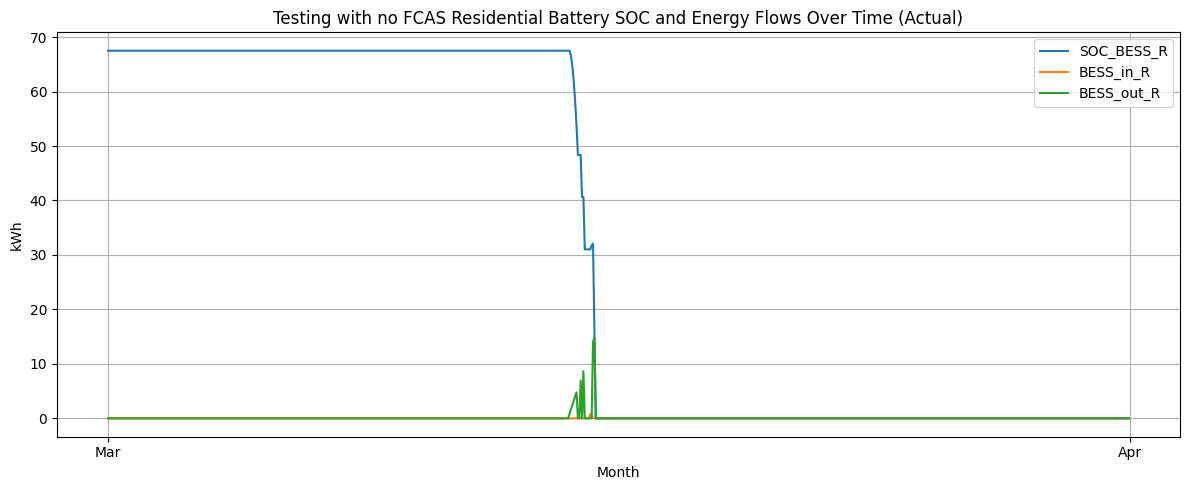

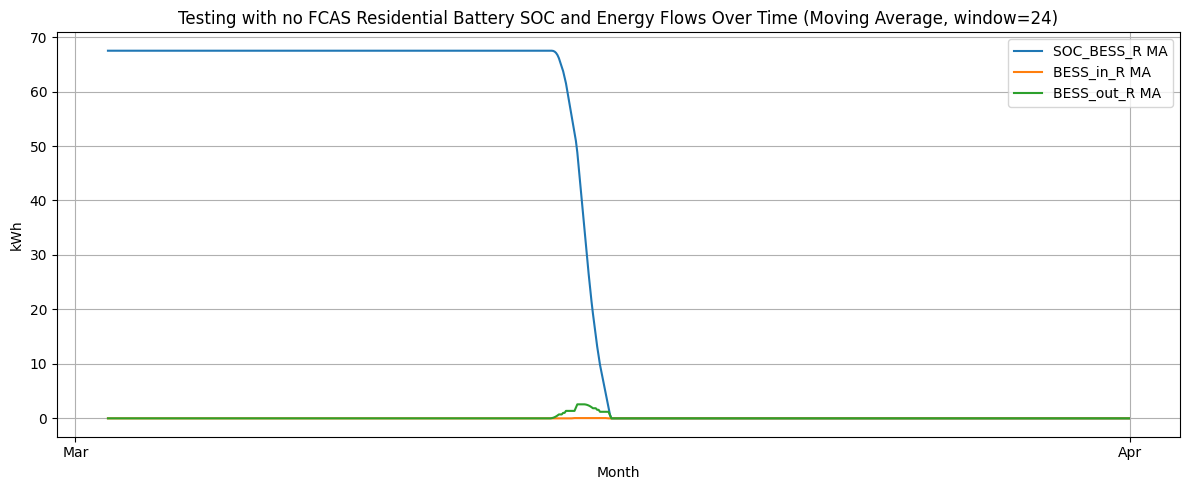

In [37]:
# --- Residential Battery (BESS_W) ---
if bess_R == 1:
    soc_r_vals = np.array([value(modelv1.SOC_BESS_R[t]) for t in timesteps])[mask]
    bess_in_r_vals = np.array([value(modelv1.BESS_in_R[t]) for t in timesteps])[mask]
    bess_out_r_vals = np.array([value(modelv1.BESS_out_R[t]) for t in timesteps])[mask]

    plot_series(
        filtered_dates,
        {'SOC_BESS_R': soc_r_vals, 'BESS_in_R': bess_in_r_vals, 'BESS_out_R': bess_out_r_vals},
        f'{name} Residential Battery SOC and Energy Flows Over Time',
        window=24  # optional moving average
    )

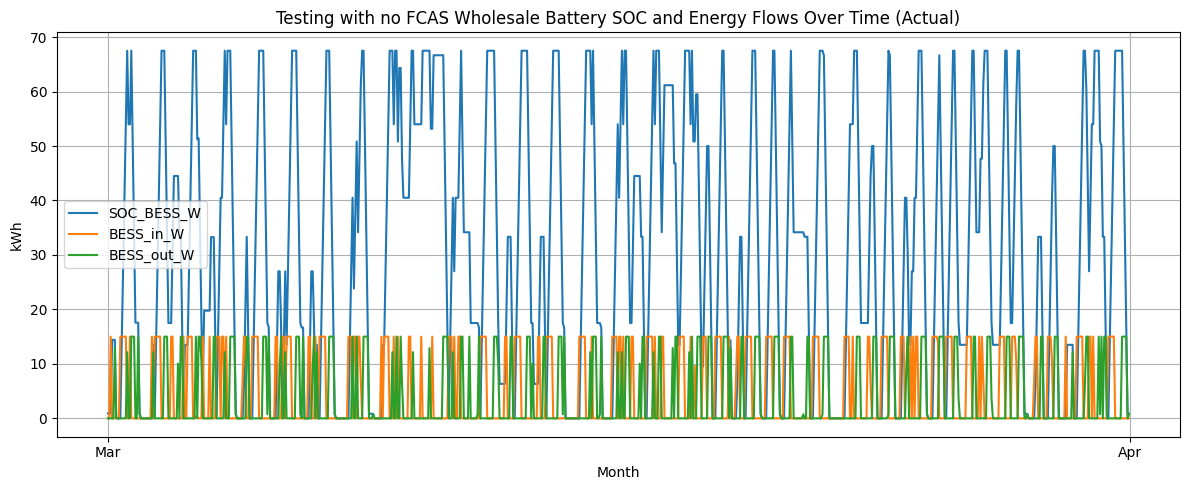

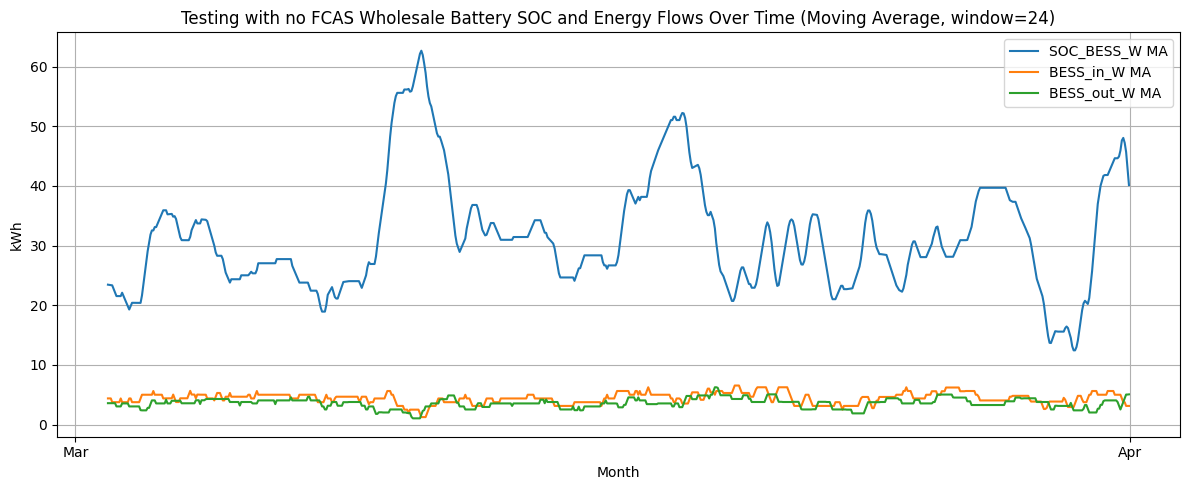

In [38]:
# --- Wholesale Battery (BESS_W) ---
if bess_W == 1:
    soc_w_vals = np.array([value(modelv1.SOC_BESS_W[t]) for t in timesteps])[mask]
    bess_in_w_vals = np.array([value(modelv1.BESS_in_W[t]) for t in timesteps])[mask]
    bess_out_w_vals = np.array([value(modelv1.BESS_out_W[t]) for t in timesteps])[mask]

    plot_series(
        filtered_dates,
        {'SOC_BESS_W': soc_w_vals, 'BESS_in_W': bess_in_w_vals, 'BESS_out_W': bess_out_w_vals},
        f'{name} Wholesale Battery SOC and Energy Flows Over Time',
        window=24  # optional moving average
    )

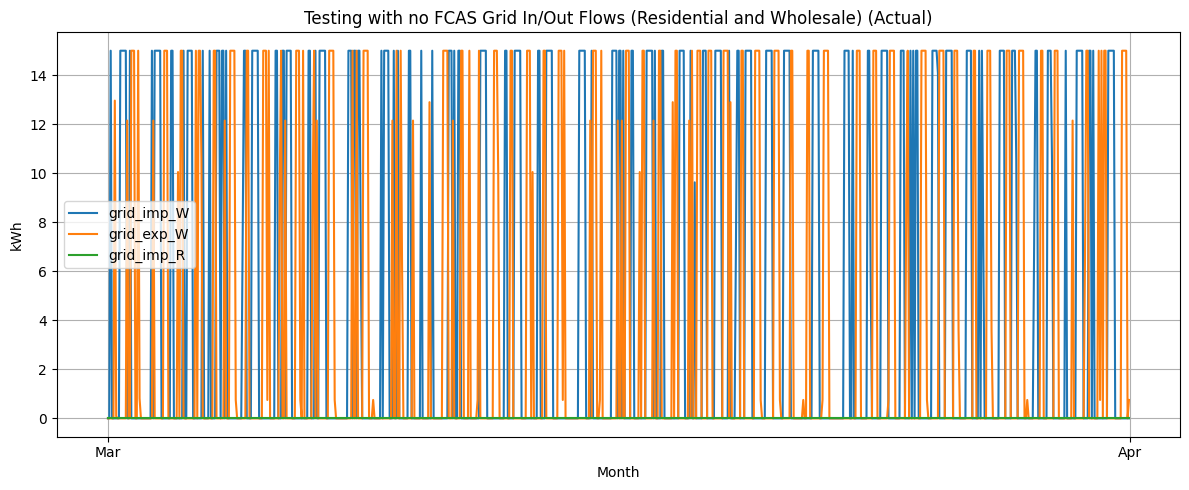

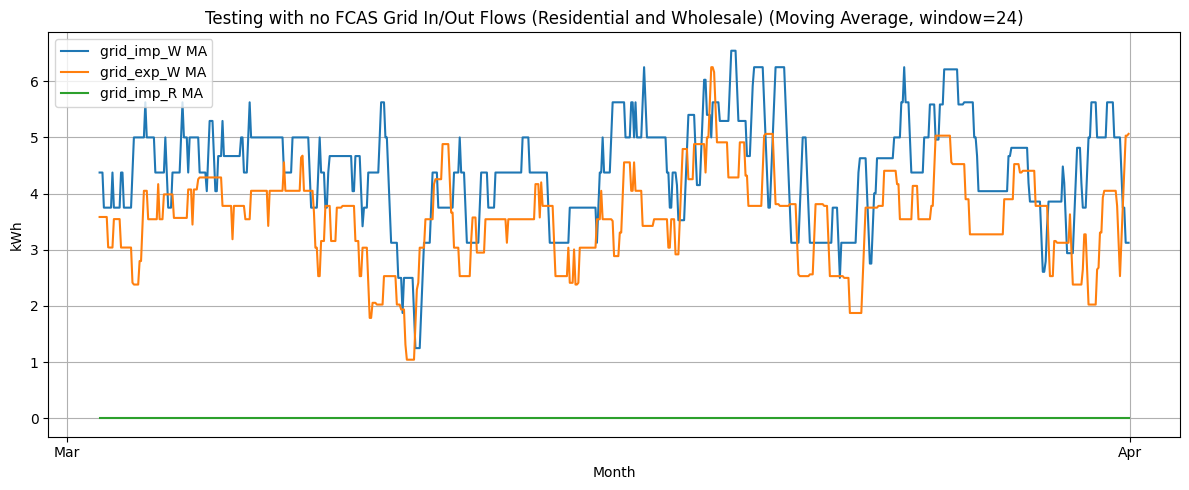

In [40]:
# --- Grid In/Out Flows ---
grid_imp_W_vals = np.array([value(modelv1.grid_imp_W[t]) for t in timesteps])[mask]
grid_exp_W_vals = np.array([value(modelv1.grid_exp_W[t]) for t in timesteps])[mask]
grid_imp_R_vals = np.array([value(modelv1.grid_imp_R[t]) for t in timesteps])[mask]

plot_series(
    filtered_dates,
    {'grid_imp_W': grid_imp_W_vals, 'grid_exp_W': grid_exp_W_vals, 'grid_imp_R': grid_imp_R_vals},
    f'{name} Grid In/Out Flows (Residential and Wholesale)',
    window = 24
)

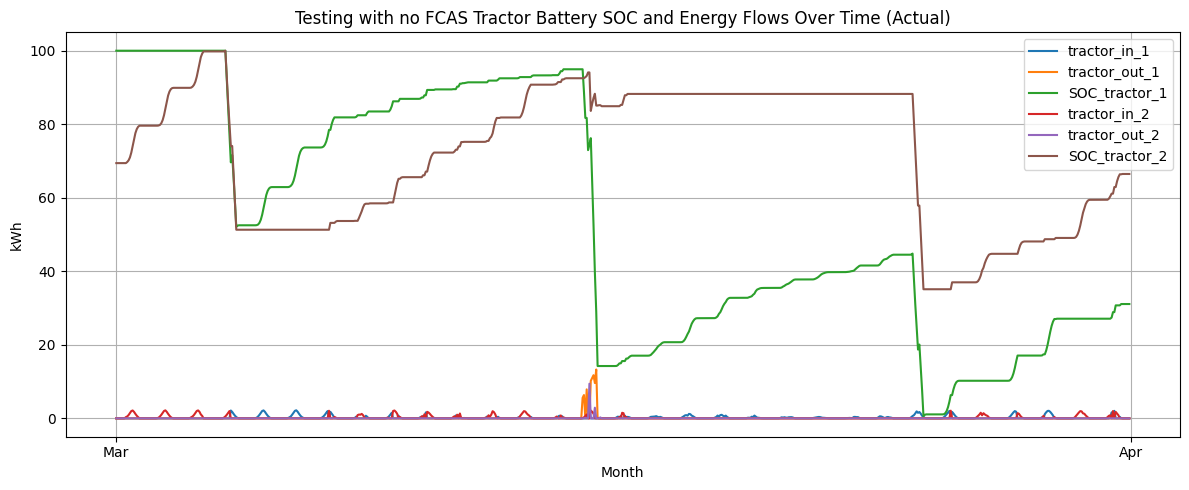

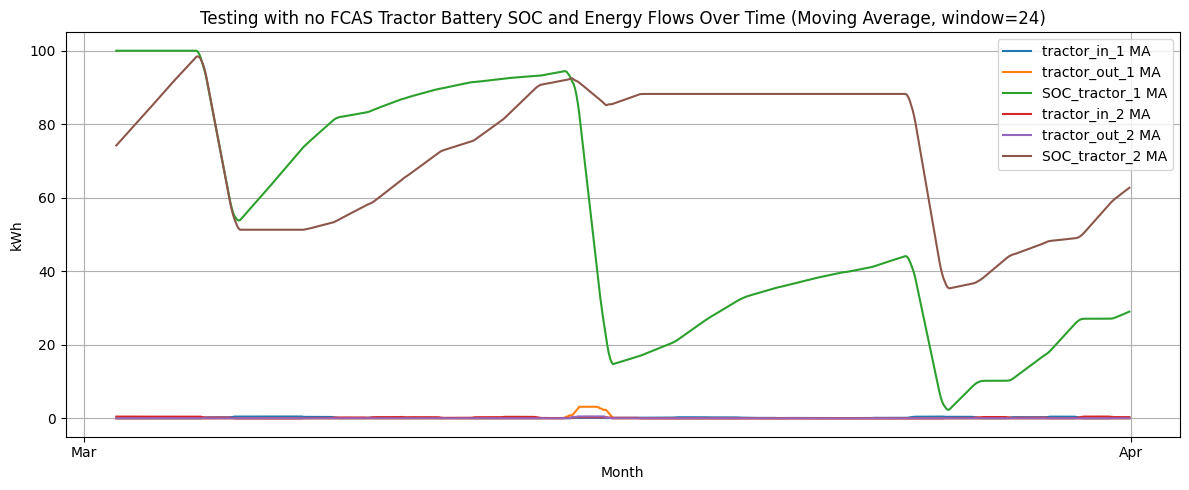

In [41]:
# --- Tractor Batteries ---
tractor_series = {}
for n in modelv1.N:
    tractor_series[f'tractor_in_{n}'] = np.array([value(modelv1.tractor_in[t,n]) for t in timesteps])[mask]
    tractor_series[f'tractor_out_{n}'] = np.array([value(modelv1.tractor_out[t,n]) for t in timesteps])[mask]
    tractor_series[f'SOC_tractor_{n}'] = np.array([value(modelv1.SOC_tractor[t,n]) for t in timesteps])[mask]

plot_series(
    filtered_dates,
    tractor_series,
    f'{name} Tractor Battery SOC and Energy Flows Over Time',
    window=24
)

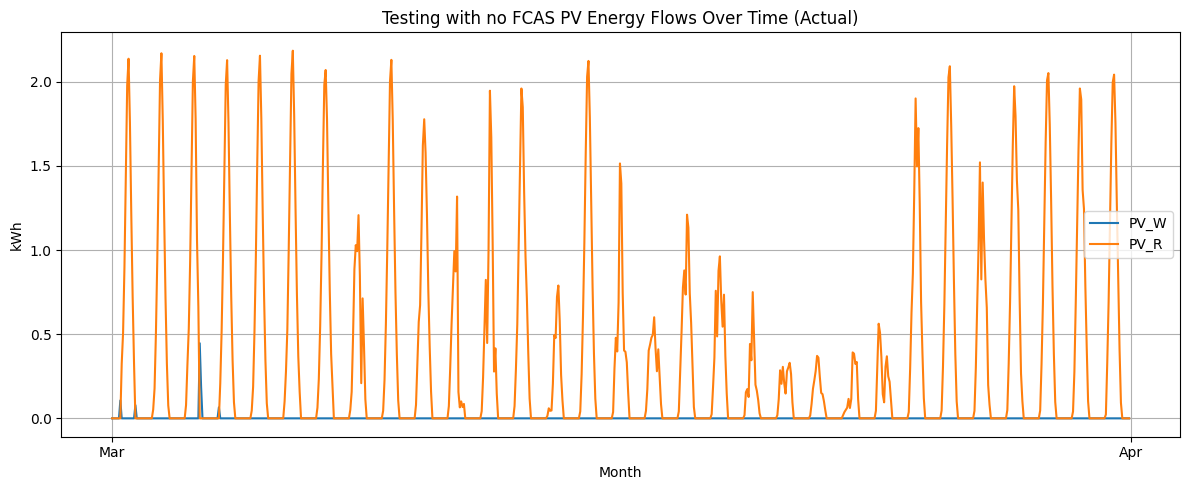

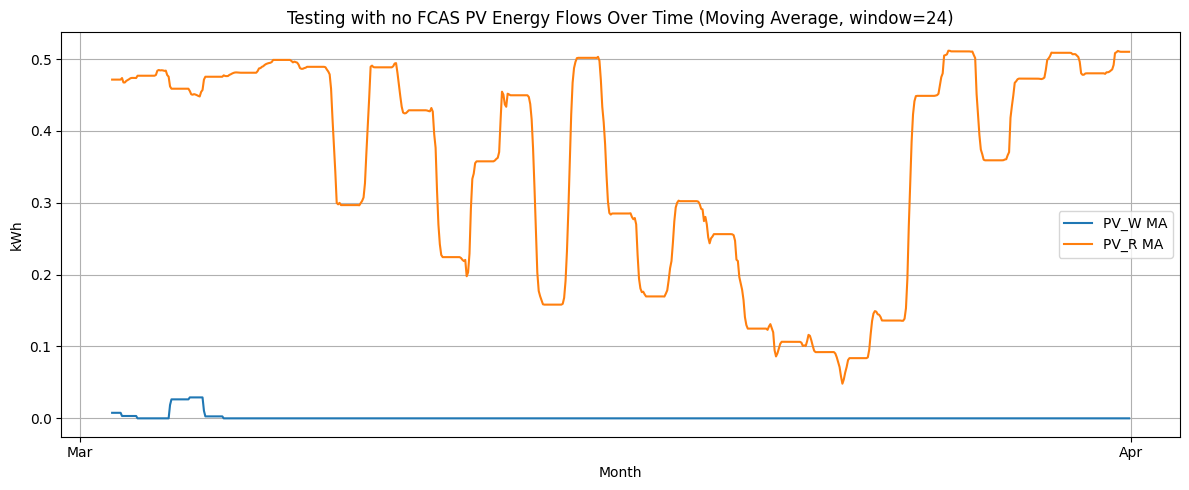

In [42]:
# --- PV Energy Flows ---
if pv == 1:
    pv_W_vals = np.array([value(modelv1.PV_W[t]) for t in timesteps])[mask]
    pv_R_vals = np.array([value(modelv1.PV_R[t]) for t in timesteps])[mask]

    plot_series(
        filtered_dates,
        {'PV_W': pv_W_vals, 'PV_R': pv_R_vals},
        f'{name} PV Energy Flows Over Time',
        window=24
    )


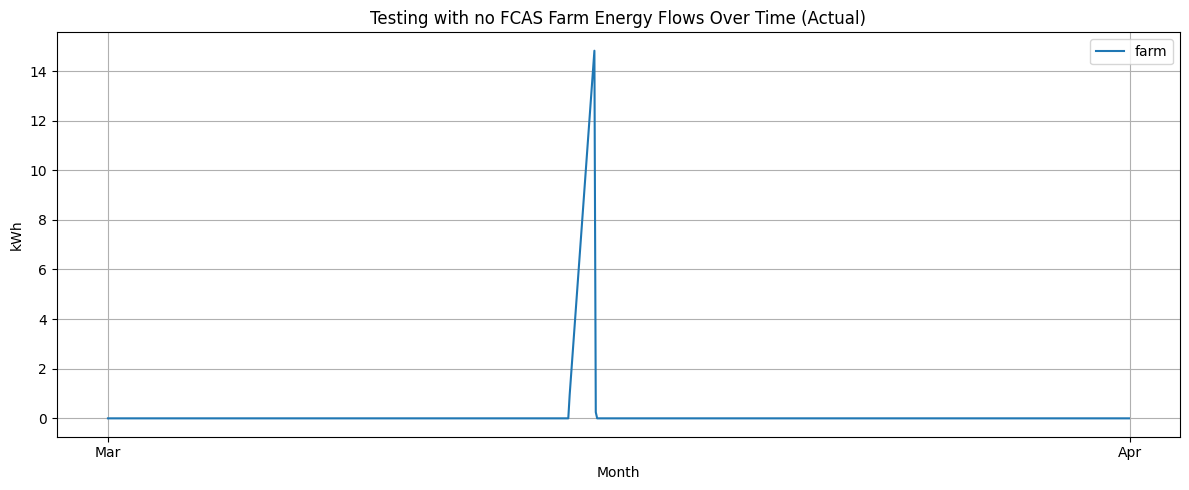

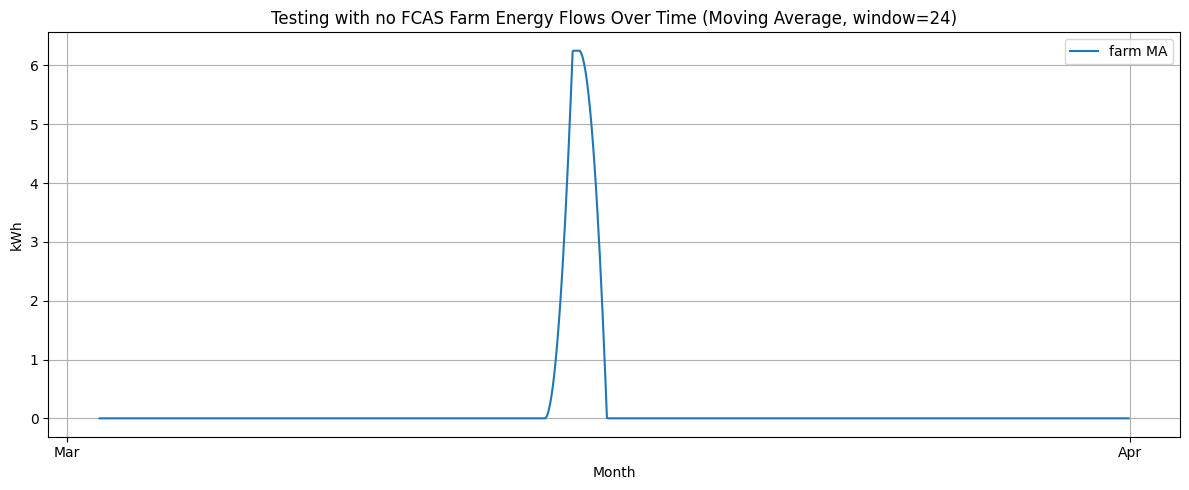

In [43]:
# --- Farm Energy ---
farm_vals = np.array([value(modelv1.farm[t]) for t in timesteps])[mask]
plot_series(filtered_dates, {'farm': farm_vals}, f'{name} Farm Energy Flows Over Time', window=24)

In [45]:
# --- FCAS Enablement ---
if fcas == 1:
    fcas_series = {
        'R1s': np.array([value(modelv1.f_R1s[t]) for t in timesteps])[mask],
        'R6s': np.array([value(modelv1.f_R6s[t]) for t in timesteps])[mask],
        'R60s': np.array([value(modelv1.f_R60s[t]) for t in timesteps])[mask],
        'R5m': np.array([value(modelv1.f_R5m[t]) for t in timesteps])[mask],
        'L1s': np.array([value(modelv1.f_L1s[t]) for t in timesteps])[mask],
        'L6s': np.array([value(modelv1.f_L6s[t]) for t in timesteps])[mask],
        'L60s': np.array([value(modelv1.f_L60s[t]) for t in timesteps])[mask],
        'L5m': np.array([value(modelv1.f_L5m[t]) for t in timesteps])[mask]
    }
    plot_series(filtered_dates, fcas_series, f'{name} Raise and Lower FCAs Enablement', ylabel='kW', window=24)

    z_series = {
        'Raise Enabled': np.array([value(modelv1.z_raise[t]) for t in timesteps])[mask],
        'Lower Enabled': np.array([value(modelv1.z_lower[t]) for t in timesteps])[mask],
        'Grid Direction': np.array([value(modelv1.grid_dir[t]) for t in timesteps])[mask]
    }
    plot_series(filtered_dates, z_series, f'{name} Raise and Lower FCAs Enablement', ylabel='kW',window=24)